In [3]:
import matplotlib.pyplot as plt
import numpy as np

In [4]:
import torch
from torch import nn,optim
from torch.autograd import Variable
import torch.nn.functional as F

In [5]:
import torchvision
from torchvision import datasets,transforms,models

In [6]:
from PIL import Image

In [7]:
%matplotlib inline
%config InlineBackend.figure_format='retina'

In [8]:
data_dir="./Data/Data/"
def load_split_train_test(data_dir,valid_size=.2):
    train_transform=transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.Resize(224),
        transforms.ToTensor()
    ])
    test_transform=transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.Resize(224),
        transforms.ToTensor()
    ])
    train_data=datasets.ImageFolder(data_dir,transform=train_transform)
    test_data=datasets.ImageFolder(data_dir,transform=test_transform)

    num_train=len(train_data)
    indices=list(range(num_train))
    split=int(np.floor(valid_size*num_train))
    np.random.shuffle(indices)

    from torch.utils.data.sampler import SubsetRandomSampler
    train_idx,test_idx=indices[split:],indices[:split]
    train_sampler=SubsetRandomSampler(train_idx)
    test_sampler=SubsetRandomSampler(test_idx)
    train_loader=torch.utils.data.DataLoader(train_data,sampler=train_sampler,batch_size=16)
    test_loader=torch.utils.data.DataLoader(test_data,sampler=test_sampler,batch_size=16)
    return train_loader,test_loader

train_loader,test_loader=load_split_train_test(data_dir,.2)
print(train_loader.dataset.classes)


['Basalt', 'Highland']


In [13]:
test_transform=transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.Resize(224),
    transforms.ToTensor()
])
def get_random_images(num):
    data=datasets.ImageFolder(data_dir,transform=test_transform)
    classes=data.classes
    indices=list(range(len(data)))
    np.random.shuffle(indices)
    idx=indices[:num]
    from torch.utils.data.sampler import SubsetRandomSampler
    sampler=SubsetRandomSampler(idx)
    loader=torch.utils.data.DataLoader(data,sampler=sampler,batch_size=num)
    dataiter=iter(loader)
    images,labels=dataiter.next()
    return images,labels

    

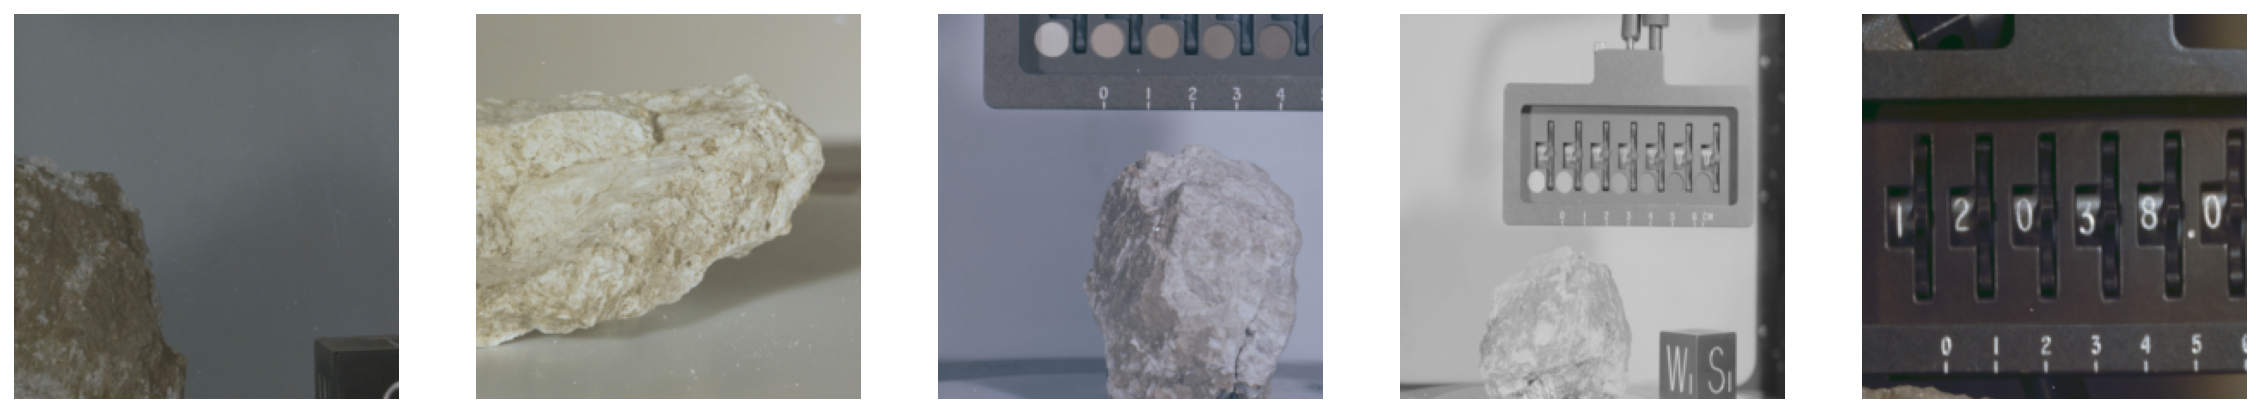

In [14]:
images,labels=get_random_images(5)
to_PIL=transforms.ToPILImage()
fig=plt.figure(figsize=(20,20))
classes=train_loader.dataset.classes
for ii in range(len(images)):
    image=to_PIL(images[ii])
    sub=fig.add_subplot(1,len(images),ii+1)
    plt.axis("off")
    plt.imshow(image)
plt.show()


In [15]:
device=torch.device("cuda" if torch.cuda.is_available() else "cpu")
model=models.resnet50(pretrained=True)

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to C:\Users\DELL/.cache\torch\hub\checkpoints\resnet50-19c8e357.pth
100%|██████████| 97.8M/97.8M [05:54<00:00, 289kB/s] 


In [16]:
for param in model.parameters():
    param.requires_grad=False

model.fc=nn.Sequential(
    nn.Linear(2048,512),
    nn.ReLU(),
    nn.Dropout(0.2),
    nn.Linear(512,2),
    nn.LogSoftmax(dim=1)
)
criterion=nn.NLLLoss()
optimizer=optim.Adam(model.fc.parameters(),lr=0.003)
model.to(device)
print("Done")

Done


In [19]:
epochs = 5
steps = 0
running_loss = 0
print_every = 5
train_losses, test_losses = [], []

for epoch in range(epochs):
    for inputs, labels in train_loader:

        steps += 1
        print('Training step ', steps)
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        logps = model.forward(inputs)
        loss = criterion(logps, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        if steps % print_every == 0:
            test_loss = 0
            accuracy = 0
            model.eval()
            with torch.no_grad():
                for inputs, labels in test_loader:
                    inputs, labels = inputs.to(device), labels.to(device)
                    logps = model.forward(inputs)
                    batch_loss = criterion(logps, labels)
                    test_loss += batch_loss.item()
                    
                    ps = torch.exp(logps)
                    top_p, top_class = ps.topk(1, dim=1)
                    equals = top_class == labels.view(*top_class.shape)
                    accuracy += torch.mean(equals.type(torch.FloatTensor)).item()

            train_losses.append(running_loss/len(train_loader))
            test_losses.append(test_loss/len(test_loader))                    
            print(f"Epoch {epoch+1}/{epochs}.. "
                  f"Train loss: {running_loss/print_every:.3f}.. "
                  f"Test loss: {test_loss/len(test_loader):.3f}.. "
                  f"Test accuracy: {accuracy/len(test_loader):.3f}")
            running_loss = 0
            model.train()

Training step  1
Training step  2
Training step  3
Training step  4
Training step  5
Epoch 1/5.. Train loss: 0.602.. Test loss: 0.629.. Test accuracy: 0.613
Training step  6
Training step  7
Training step  8
Training step  9
Training step  10
Epoch 2/5.. Train loss: 0.361.. Test loss: 0.368.. Test accuracy: 0.904
Training step  11
Training step  12
Training step  13
Training step  14
Training step  15
Epoch 2/5.. Train loss: 0.526.. Test loss: 0.685.. Test accuracy: 0.548
Training step  16
Training step  17
Training step  18
Training step  19
Training step  20
Epoch 3/5.. Train loss: 0.296.. Test loss: 0.251.. Test accuracy: 0.902
Training step  21
Training step  22
Training step  23
Training step  24
Training step  25
Epoch 4/5.. Train loss: 0.508.. Test loss: 0.385.. Test accuracy: 0.802
Training step  26
Training step  27
Training step  28
Training step  29
Training step  30
Epoch 4/5.. Train loss: 0.442.. Test loss: 0.300.. Test accuracy: 0.873
Training step  31
Training step  32
T

In [20]:
print(accuracy/len(test_loader))

0.9354166686534882


In [21]:
torch.save(model,"aerialmodel.pth")

In [22]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model=torch.load('aerialmodel.pth')

In [27]:
def predict_image(image):
    image_tensor = test_transform(image).float()
    image_tensor = image_tensor.unsqueeze_(0)
    input = Variable(image_tensor)
    input = input.to(device)
    output = model(input)
    index = output.data.cpu().numpy().argmax()
    return index

In [28]:
images, labels = get_random_images(5)

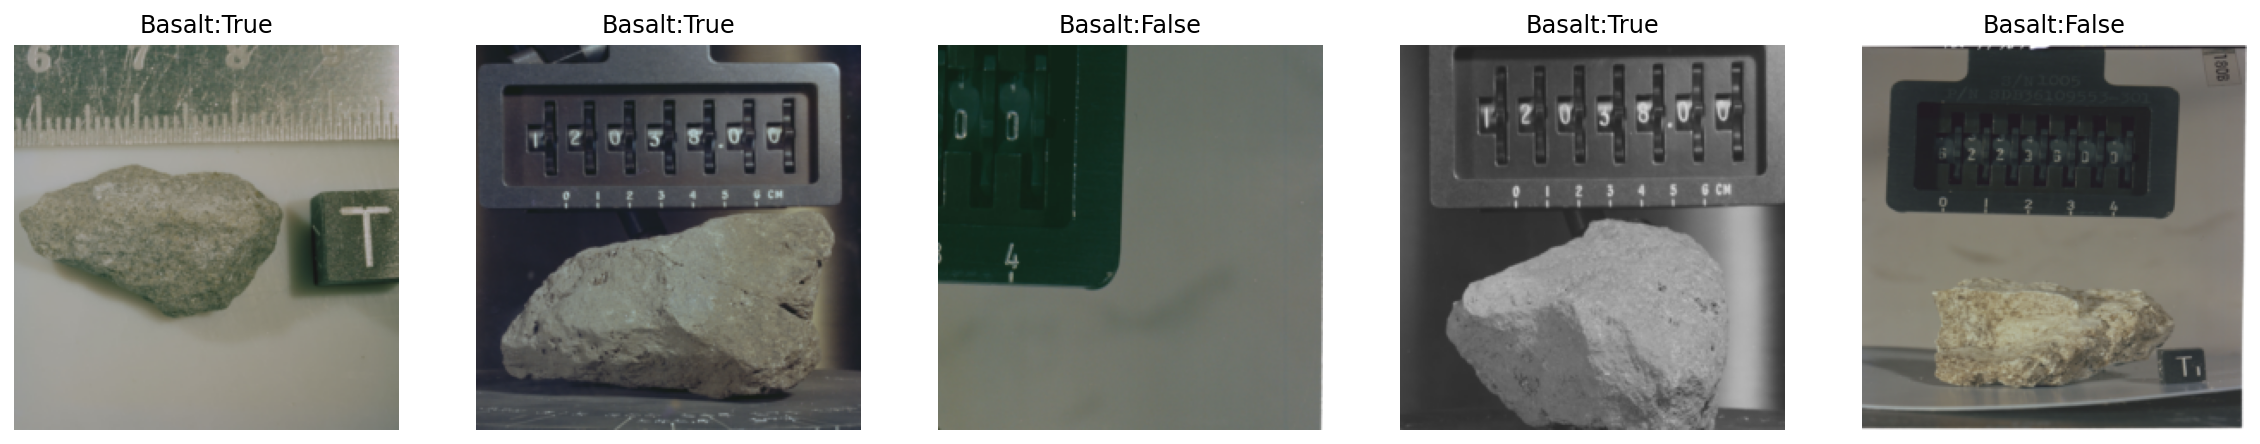

In [29]:
to_pil = transforms.ToPILImage()
images, labels = get_random_images(5)
fig=plt.figure(figsize=(20,10))

classes=train_loader.dataset.classes
for ii in range(len(images)):
    image = to_pil(images[ii])
    index = predict_image(image)
    sub = fig.add_subplot(1, len(images), ii+1)
    res = int(labels[ii]) == index
    sub.set_title(str(classes[index]) + ":" + str(res))
    plt.axis('off')
    plt.imshow(image)
plt.show()